In [37]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import json
import sys
import os
import multiprocessing
import csv

from tqdm import tqdm, tqdm_notebook
from urllib import request
from PIL import Image
from io import BytesIO
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from fastai.fastai.dataset import ImageClassifierData, get_cv_idxs
from fastai.fastai.conv_learner import ConvLearner
from fastai.fastai.transforms import tfms_from_model, transforms_side_on
from fastai.fastai.torch_imports import resnext101_64
import torch
import pandas as pd
from IPython.display import FileLink

In [38]:
torch.cuda.is_available()

True

## Functions

In [39]:
def download_image(img_data, prefix, path):
    filename = os.path.join(path, prefix, f"{img_data['imageId']}.jpg")

    if os.path.exists(filename):
        return 0

    try:
        response = request.urlopen(img_data['url'])
        image_data = response.read()
        pil_image = Image.open(BytesIO(image_data))
        pil_image_rgb = pil_image.convert('RGB')
        pil_image_rgb.save(filename, format='JPEG', quality=90)
    except Exception as e:
        return 1

    return 0


def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    """Metric used to evaluate model performance."""
    return max([f1_score(targs, (preds>th), average='samples') for th in np.arange(start, end, step)])

## Settings

In [43]:
PATH = './data/imaterialist/'
sz = 64
arch = resnext101_64
metrics = [f1]
bs = 64
num_train_images = 100000

## Download Kaggle files

Note: only need to run once.

In [4]:
!mkdir  -p {PATH}

In [6]:
!kaggle competitions download -c imaterialist-challenge-fashion-2018 --path={PATH}

test.json.zip: Downloaded 644KB of 644KB
validation.json.zip: Downloaded 296KB of 296KB
train.json.zip: Downloaded 26MB of 26MB
sample_submission.csv.zip: Downloaded 477KB of 477KB


In [3]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}{file}

In [28]:
!mkdir {PATH}train
!mkdir {PATH}val
!mkdir {PATH}test

## Download images

In [8]:
train_json = json.load(open(f'{PATH}train.json'))

### Download train images

In [14]:
def _download_train_image(img):
    return download_image(img, 'train', PATH)

pool = multiprocessing.Pool(processes=20)
failures = sum(
    tqdm_notebook(pool.imap_unordered(
        _download_train_image,
        train_json['images'][:num_train_images]
    ), total=num_train_images if num_train_images else len(train_json['images'])))
print('Total number of download failures:', failures)
pool.close()
pool.terminate()


Total number of download failures: 1598


### Download test images

In [39]:
test_json = json.load(open('./data/imaterialist/test.json'))

In [40]:
def _download_test_image(img):
    return download_image(img, 'test', PATH)

pool = multiprocessing.Pool(processes=20)
failures = sum(
    tqdm_notebook(pool.imap_unordered(
        _download_test_image,
        test_json['images']
    ), total=len(test_json['images'])))
print('Total number of download failures:', failures)
pool.close()
pool.terminate()

Total number of download failures: 0


## Training

### Prepare training data

In [44]:
train_labels = []
train_imgs = []

for img in train_json['annotations'][:num_train_images]:
    filename = f'{img["imageId"]}.jpg'
                
    filepath = os.path.join(PATH, 'train', filename)
    
    if os.path.exists(filepath):
        train_imgs.append(os.path.join('train', filename))
    
        # More intuitive to work with ints, imo
        train_labels.append([int(i) for i in img['labelId']])

In [45]:
len(train_labels)

98549

### Setup one-hot y encoding

In [46]:
mlb = MultiLabelBinarizer()
y_transformed = np.float32(mlb.fit_transform(train_labels))

In [47]:
len(mlb.classes_)

227

In [48]:
y_transformed.shape

(98549, 227)

In [49]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [50]:
val_idxs = get_cv_idxs(len(train_imgs), val_pct=0.1)

In [51]:
len(val_idxs)

9854

In [52]:
data = ImageClassifierData.from_names_and_array(
    PATH, train_imgs, y_transformed, mlb.classes_,
    tfms=tfms, val_idxs=val_idxs, test_name='test', bs=bs)

In [54]:
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)


100%|██████████| 621/621 [02:53<00:00,  3.58it/s]


### Find best learning rate

In [55]:
learn.lr_find()

epoch      trn_loss   val_loss   f1                             
    0      0.078496   0.074238   0.423354  



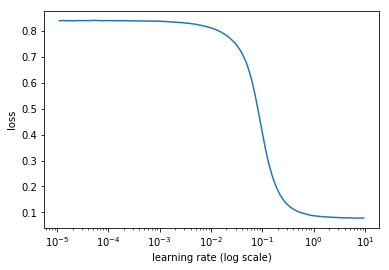

In [56]:
learn.sched.plot()

In [57]:
lr = 10

### Train with precomputed activations

In [58]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   f1                             
    0      0.072273   0.069285   0.456609  
    1      0.071188   0.068876   0.456095                       



[array([0.06888]), 0.4560945488084087]

### Train with data augmentations

In [59]:
learn.precompute = False

In [62]:
lr = 1

In [63]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   f1                             
    0      0.070002   0.067294   0.471036  
    1      0.070063   0.067152   0.471762                       



[array([0.06715]), 0.4717624830965164]

### Train earlier layers

In [64]:
learn.unfreeze()

In [66]:
lrs = np.array([lr/9, lr/3, lr])

In [67]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  1%|          | 7/1386 [00:07<25:25,  1.11s/it, loss=0.0846]  


Exception in thread Thread-23:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f1                             
    0      0.064145   0.061145   0.521773  
    1      0.061164   0.059003   0.536325                       
    2      0.058597   0.058029   0.54471                        
    3      0.059371   0.057988   0.543936                       
    4      0.057016   0.056844   0.554324                       
    5      0.054069   0.056361   0.557715                       
    6      0.052478   0.056325   0.558973                       



[array([0.05632]), 0.5589733877173501]

In [68]:
learn.save(f'resnext101_64_{sz}')

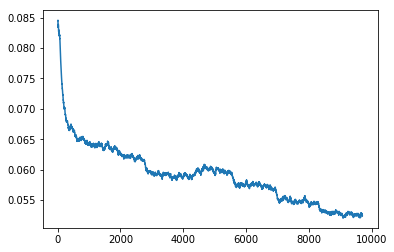

In [73]:
learn.sched.plot_loss()

In [69]:
learn.load(f'resnext101_64_{sz}')

In [70]:
tta = learn.TTA()

In [71]:
log_preds, targs = tta

In [72]:
f1(np.mean(log_preds, axis=0), targs)

0.5604347351669788

## Prepare test output

In [74]:
log_test_preds, test_targs = learn.TTA(is_test=True)

In [75]:
log_test_preds.shape

(5, 39706, 227)

In [76]:
test_preds = np.mean(log_test_preds, axis=0)

In [77]:
lbls = test_preds>0.2

In [78]:
def get_labels(a): return [data.classes[o] for o in a.nonzero()[0]]

In [79]:
print(get_labels(lbls[0]))

[7, 66, 171]


In [80]:
res = [get_labels(o) for o in lbls]

In [81]:
data.test_dl.dataset.fnames[0][5:-4]

'23668'

In [82]:
outp = pd.DataFrame({
    'image_id': [f[5:-4] for f in data.test_dl.dataset.fnames],
    'label_id': [' '.join(str(i) for i in l) for l in res]
})
outp.head()

,image_id,label_id
0,23668,7 66 171
1,2957,7 44 66 153 171 175 193 222
2,11706,17 66 100 137 176 227
3,10629,17 44 62 66 122 171 186 214
4,9810,20 62 66 131 153 171


In [83]:
outp.to_csv(f'{PATH}tmp/submission_2.gz', compression='gzip', index=None)

In [84]:
FileLink(f'{PATH}tmp/submission_2.gz')

/home/ubuntu/study-notes/moocs/fast.ai/deep-learning-2018/data/imaterialist/tmp/submission_2.gz

"Your submission scored 0.53362"